In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import norm
from statsmodels.graphics.api import qqplot
from scipy.optimize import minimize

In [3]:
#data_path = "C:/Users/jasonting/Downloads/TemperatureData.csv"
file_path = r"/Users/jasonting/Downloads/TemperatureData.csv" 
temperature_data = pd.read_csv(file_path)

In [4]:
temperature_data.head()

,NAME,DATE,PRCP,TMAX,TMIN,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,"ABILENE REGIONAL AIRPORT, TX US",1/1/1985,0.15,35.0,21.0,NaN,NaN,NaN,NaN,NaN
1,"ABILENE REGIONAL AIRPORT, TX US",1/2/1985,0.00,29.0,20.0,NaN,NaN,NaN,NaN,NaN
2,"ABILENE REGIONAL AIRPORT, TX US",1/3/1985,0.00,44.0,21.0,NaN,NaN,NaN,NaN,NaN
3,"ABILENE REGIONAL AIRPORT, TX US",1/4/1985,0.00,52.0,27.0,NaN,NaN,NaN,NaN,NaN
4,"ABILENE REGIONAL AIRPORT, TX US",1/5/1985,0.00,51.0,30.0,NaN,NaN,NaN,NaN,NaN


In [5]:
temperature_data.describe()

,PRCP,TMAX,TMIN,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
count,14395.000000,14395.000000,14395.000000,0.0,0.0,0.0,0.0,0.0
mean,0.068619,76.991872,53.392914,NaN,NaN,NaN,NaN,NaN
std,0.280568,16.876078,16.349634,NaN,NaN,NaN,NaN,NaN
min,0.000000,11.000000,-7.000000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,66.000000,40.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,79.000000,55.000000,NaN,NaN,NaN,NaN,NaN
75%,0.000000,91.000000,68.000000,NaN,NaN,NaN,NaN,NaN
max,8.260000,111.000000,84.000000,NaN,NaN,NaN,NaN,NaN


In [6]:
temperature_data['DATE'] = pd.to_datetime(temperature_data['DATE'], format='%m/%d/%Y')

In [7]:
temperature_data

,NAME,DATE,PRCP,TMAX,TMIN,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,"ABILENE REGIONAL AIRPORT, TX US",1985-01-01,0.15,35.0,21.0,NaN,NaN,NaN,NaN,NaN
1,"ABILENE REGIONAL AIRPORT, TX US",1985-01-02,0.00,29.0,20.0,NaN,NaN,NaN,NaN,NaN
2,"ABILENE REGIONAL AIRPORT, TX US",1985-01-03,0.00,44.0,21.0,NaN,NaN,NaN,NaN,NaN
3,"ABILENE REGIONAL AIRPORT, TX US",1985-01-04,0.00,52.0,27.0,NaN,NaN,NaN,NaN,NaN
4,"ABILENE REGIONAL AIRPORT, TX US",1985-01-05,0.00,51.0,30.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14391,"ABILENE REGIONAL AIRPORT, TX US",2024-05-27,0.00,103.0,60.0,NaN,NaN,NaN,NaN,NaN
14392,"ABILENE REGIONAL AIRPORT, TX US",2024-05-28,0.00,91.0,68.0,NaN,NaN,NaN,NaN,NaN
14393,"ABILENE REGIONAL AIRPORT, TX US",2024-05-29,0.33,88.0,66.0,NaN,NaN,NaN,NaN,NaN
14394,"ABILENE REGIONAL AIRPORT, TX US",2024-05-30,2.72,83.0,64.0,NaN,NaN,NaN,NaN,NaN


In [8]:
temperature_data.drop(columns=[col for col in temperature_data if col.startswith('Unnamed')], inplace=True)

In [9]:
temperature_data.dropna(subset=['NAME', 'DATE', 'PRCP', 'TMAX', 'TMIN'], inplace=True)

In [10]:
temperature_data

,NAME,DATE,PRCP,TMAX,TMIN
0,"ABILENE REGIONAL AIRPORT, TX US",1985-01-01,0.15,35.0,21.0
1,"ABILENE REGIONAL AIRPORT, TX US",1985-01-02,0.00,29.0,20.0
2,"ABILENE REGIONAL AIRPORT, TX US",1985-01-03,0.00,44.0,21.0
3,"ABILENE REGIONAL AIRPORT, TX US",1985-01-04,0.00,52.0,27.0
4,"ABILENE REGIONAL AIRPORT, TX US",1985-01-05,0.00,51.0,30.0
...,...,...,...,...,...
14390,"ABILENE REGIONAL AIRPORT, TX US",2024-05-26,0.00,102.0,73.0
14391,"ABILENE REGIONAL AIRPORT, TX US",2024-05-27,0.00,103.0,60.0
14392,"ABILENE REGIONAL AIRPORT, TX US",2024-05-28,0.00,91.0,68.0
14393,"ABILENE REGIONAL AIRPORT, TX US",2024-05-29,0.33,88.0,66.0


In [11]:
#Ensure that PRCP, TMAX, and TMIN are floats
temperature_data['PRCP'] = temperature_data['PRCP'].astype(float)
temperature_data['TMAX'] = temperature_data['TMAX'].astype(float)
temperature_data['TMIN'] = temperature_data['TMIN'].astype(float)

In [12]:
temperature_data

,NAME,DATE,PRCP,TMAX,TMIN
0,"ABILENE REGIONAL AIRPORT, TX US",1985-01-01,0.15,35.0,21.0
1,"ABILENE REGIONAL AIRPORT, TX US",1985-01-02,0.00,29.0,20.0
2,"ABILENE REGIONAL AIRPORT, TX US",1985-01-03,0.00,44.0,21.0
3,"ABILENE REGIONAL AIRPORT, TX US",1985-01-04,0.00,52.0,27.0
4,"ABILENE REGIONAL AIRPORT, TX US",1985-01-05,0.00,51.0,30.0
...,...,...,...,...,...
14390,"ABILENE REGIONAL AIRPORT, TX US",2024-05-26,0.00,102.0,73.0
14391,"ABILENE REGIONAL AIRPORT, TX US",2024-05-27,0.00,103.0,60.0
14392,"ABILENE REGIONAL AIRPORT, TX US",2024-05-28,0.00,91.0,68.0
14393,"ABILENE REGIONAL AIRPORT, TX US",2024-05-29,0.33,88.0,66.0


In [13]:
print(temperature_data.describe())

                                DATE          PRCP          TMAX          TMIN
count                          14395  14395.000000  14395.000000  14395.000000
mean   2004-09-14 23:59:59.999999872      0.068619     76.991872     53.392914
min              1985-01-01 00:00:00      0.000000     11.000000     -7.000000
25%              1994-11-08 12:00:00      0.000000     66.000000     40.000000
50%              2004-09-15 00:00:00      0.000000     79.000000     55.000000
75%              2014-07-23 12:00:00      0.000000     91.000000     68.000000
max              2024-05-30 00:00:00      8.260000    111.000000     84.000000
std                              NaN      0.280568     16.876078     16.349634


In [14]:
temperature_data.set_index('DATE', inplace=True)

In [15]:
temperature_data

,NAME,PRCP,TMAX,TMIN
DATE,,,,
1985-01-01,"ABILENE REGIONAL AIRPORT, TX US",0.15,35.0,21.0
1985-01-02,"ABILENE REGIONAL AIRPORT, TX US",0.00,29.0,20.0
1985-01-03,"ABILENE REGIONAL AIRPORT, TX US",0.00,44.0,21.0
1985-01-04,"ABILENE REGIONAL AIRPORT, TX US",0.00,52.0,27.0
1985-01-05,"ABILENE REGIONAL AIRPORT, TX US",0.00,51.0,30.0
...,...,...,...,...
2024-05-26,"ABILENE REGIONAL AIRPORT, TX US",0.00,102.0,73.0
2024-05-27,"ABILENE REGIONAL AIRPORT, TX US",0.00,103.0,60.0
2024-05-28,"ABILENE REGIONAL AIRPORT, TX US",0.00,91.0,68.0


In [16]:
temperature_data['MONTH'] = temperature_data.index.month

In [17]:
temperature_data

,NAME,PRCP,TMAX,TMIN,MONTH
DATE,,,,,
1985-01-01,"ABILENE REGIONAL AIRPORT, TX US",0.15,35.0,21.0,1
1985-01-02,"ABILENE REGIONAL AIRPORT, TX US",0.00,29.0,20.0,1
1985-01-03,"ABILENE REGIONAL AIRPORT, TX US",0.00,44.0,21.0,1
1985-01-04,"ABILENE REGIONAL AIRPORT, TX US",0.00,52.0,27.0,1
1985-01-05,"ABILENE REGIONAL AIRPORT, TX US",0.00,51.0,30.0,1
...,...,...,...,...,...
2024-05-26,"ABILENE REGIONAL AIRPORT, TX US",0.00,102.0,73.0,5
2024-05-27,"ABILENE REGIONAL AIRPORT, TX US",0.00,103.0,60.0,5
2024-05-28,"ABILENE REGIONAL AIRPORT, TX US",0.00,91.0,68.0,5


In [18]:
#Calculate HDD and CDD with reference base temperatures
def calculate_degree_days(temps, base_temp=65):
    HDD = np.maximum(0, base_temp - temps)
    CDD = np.maximum(0, temps - base_temp)
    return HDD, CDD

In [19]:
#USA seasonal masks
winter_season = (temperature_data['MONTH'].isin([10, 11, 12, 1, 2, 3]))
summer_season = (temperature_data['MONTH'].isin([4, 5, 6, 7, 8, 9]))


In [20]:
temperature_data['WINTER'] = winter_season.astype(int)
temperature_data['SUMMER'] = summer_season.astype(int)

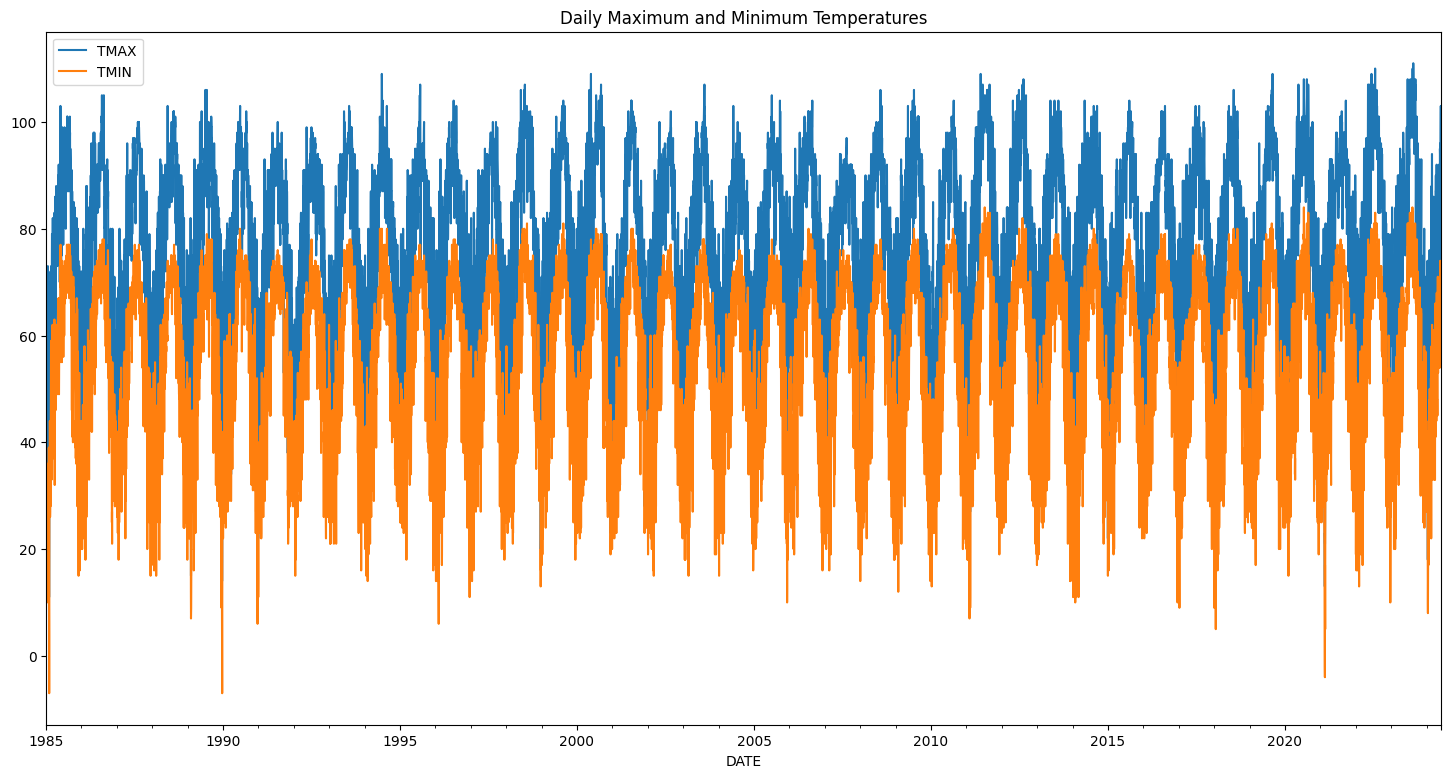

In [21]:
temperature_data[['TMAX', 'TMIN']].plot(figsize=(18, 9), title='Daily Maximum and Minimum Temperatures')
plt.show()

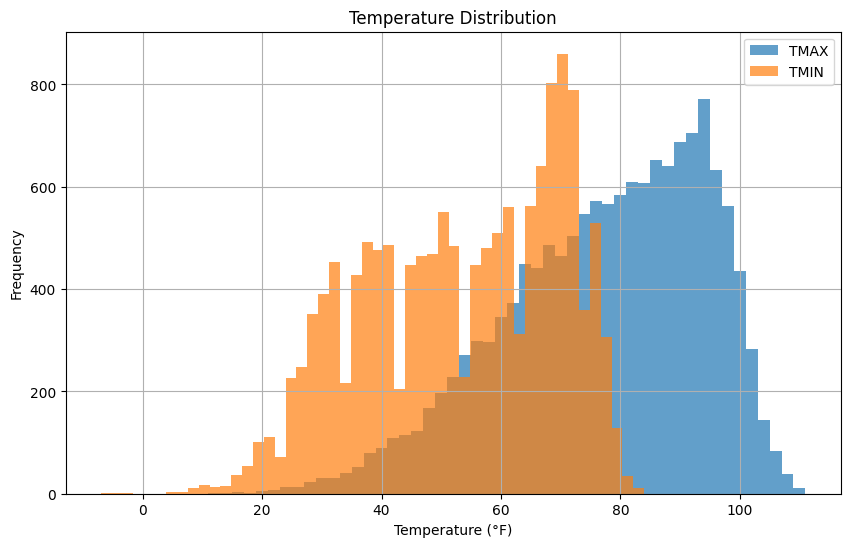

In [22]:
#Temperature distributions
plt.figure(figsize=(10, 6))
temperature_data['TMAX'].hist(bins=50, alpha=0.7, label='TMAX')
temperature_data['TMIN'].hist(bins=50, alpha=0.7, label='TMIN')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [23]:
temperature_data['TMAX Log'] = np.log(temperature_data['TMAX'], label='Daily Maximum Log Degrees')
temperature_data['TMIN Log'] = np.log(temperature_data['TMIN'], label='Daily Minimum Log Degress')
temperature_data['TMAX Log'].hist(bins=50)
temperature_data['TMIN Log'].hist(bins=50);plt.title('Logged Transformed Temperature')
plt.show()

plt.hist(temperature_data[['TMAX Log','TMIN Log']].mean(axis=1),bins =50); plt.title('Logged Transform & Combined Temperature')

TypeError: log() got an unexpected keyword argument 'label'

(array([  2.,   2.,   3.,   2.,   5.,   3.,  14.,  12.,  12.,  24.,  40.,
         38.,  52.,  52., 108., 122., 124., 192., 275., 221., 355., 377.,
        341., 447., 321., 450., 471., 358., 482., 468., 367., 528., 536.,
        405., 560., 572., 463., 584., 464., 653., 723., 576., 793., 671.,
        393., 400., 202.,  71.,  51.,  10.]),
 array([ 5.5 ,  7.32,  9.14, 10.96, 12.78, 14.6 , 16.42, 18.24, 20.06,
        21.88, 23.7 , 25.52, 27.34, 29.16, 30.98, 32.8 , 34.62, 36.44,
        38.26, 40.08, 41.9 , 43.72, 45.54, 47.36, 49.18, 51.  , 52.82,
        54.64, 56.46, 58.28, 60.1 , 61.92, 63.74, 65.56, 67.38, 69.2 ,
        71.02, 72.84, 74.66, 76.48, 78.3 , 80.12, 81.94, 83.76, 85.58,
        87.4 , 89.22, 91.04, 92.86, 94.68, 96.5 ]),
 <BarContainer object of 50 artists>)

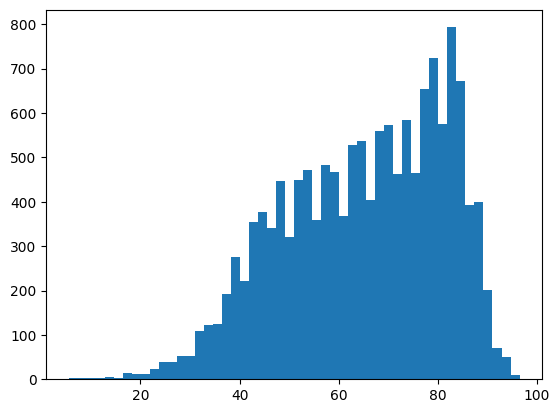

In [24]:
plt.hist(temperature_data[['TMAX','TMIN']].mean(axis=1),bins =50)

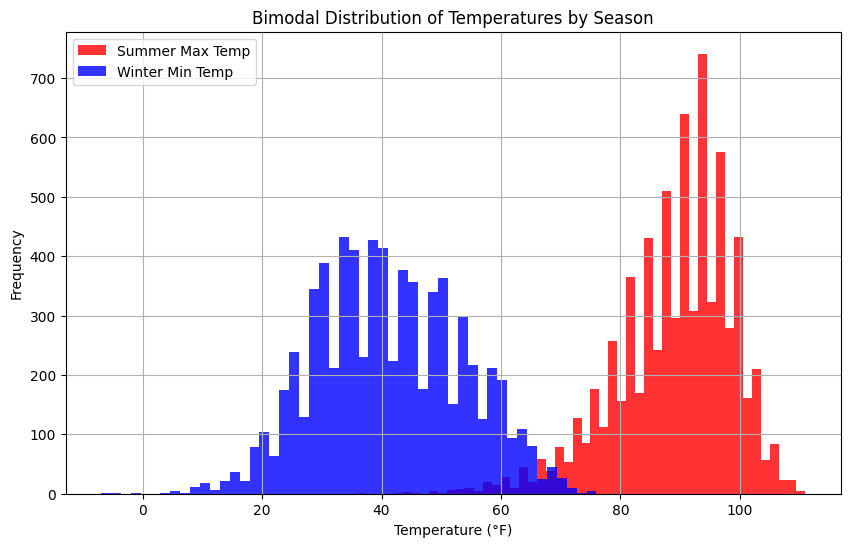

In [25]:
#Seasonal temperature histograms
plt.figure(figsize=(10, 6))
temperature_data[temperature_data['SUMMER'] == 1]['TMAX'].hist(bins=50, color = 'red', alpha=0.8, label='Summer Max Temp')
temperature_data[temperature_data['WINTER'] == 1]['TMIN'].hist(bins=50, color = 'blue', alpha=0.8, label='Winter Min Temp')
plt.title('Bimodal Distribution of Temperatures by Season')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [26]:
temperature_data

,NAME,PRCP,TMAX,TMIN,MONTH,WINTER,SUMMER
DATE,,,,,,,
1985-01-01,"ABILENE REGIONAL AIRPORT, TX US",0.15,35.0,21.0,1,1,0
1985-01-02,"ABILENE REGIONAL AIRPORT, TX US",0.00,29.0,20.0,1,1,0
1985-01-03,"ABILENE REGIONAL AIRPORT, TX US",0.00,44.0,21.0,1,1,0
1985-01-04,"ABILENE REGIONAL AIRPORT, TX US",0.00,52.0,27.0,1,1,0
1985-01-05,"ABILENE REGIONAL AIRPORT, TX US",0.00,51.0,30.0,1,1,0
...,...,...,...,...,...,...,...
2024-05-26,"ABILENE REGIONAL AIRPORT, TX US",0.00,102.0,73.0,5,0,1
2024-05-27,"ABILENE REGIONAL AIRPORT, TX US",0.00,103.0,60.0,5,0,1
2024-05-28,"ABILENE REGIONAL AIRPORT, TX US",0.00,91.0,68.0,5,0,1


In [27]:
## Fast Fourier Transformation

#def fft(temp): 
   # evens = temp[np.arange(1,len(temperature_data),2)]
    #odds = temp[np.arange(0,len(temperature_data),2)]
    #for i in range(len((temp/2))):
       # evens[i] * np.exp(np.pi * -2j * i/n) * odds[i]
    
    
    
#fft(temperature_data['TMAX'])
    

In [28]:
monthly_extremes = temperature_data.groupby('MONTH').agg({
    'TMAX': ['max', 'min'],
    'TMIN': ['max', 'min']
})

In [29]:
monthly_extremes.columns = ['_'.join(col).strip() for col in monthly_extremes.columns.values]  # Flatten the column hierarchy
monthly_extremes.reset_index(inplace=True)

In [30]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_extremes['NAME_MONTH'] = monthly_extremes['MONTH'].apply(lambda x: months[x-1])


In [31]:
print(monthly_extremes[['NAME_MONTH', 'TMAX_max', 'TMAX_min', 'TMIN_max', 'TMIN_min']])


   NAME_MONTH  TMAX_max  TMAX_min  TMIN_max  TMIN_min
0         Jan      87.0      18.0      61.0       5.0
1         Feb      94.0      11.0      63.0      -7.0
2         Mar      95.0      25.0      68.0      11.0
3         Apr     104.0      36.0      74.0      27.0
4         May     109.0      52.0      79.0      33.0
5         Jun     109.0      69.0      81.0      52.0
6         Jul     110.0      68.0      84.0      57.0
7         Aug     111.0      70.0      84.0      50.0
8         Sep     108.0      53.0      81.0      38.0
9         Oct     100.0      32.0      76.0      20.0
10        Nov      93.0      28.0      68.0      16.0
11        Dec      90.0      12.0      64.0      -7.0


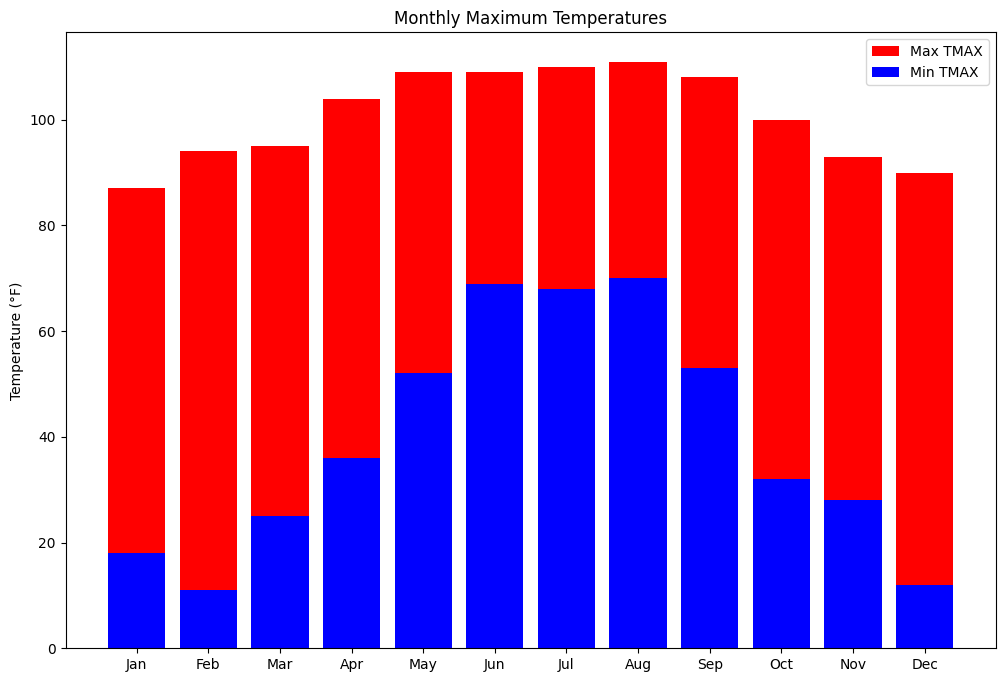

In [32]:
#Plotting max and min temperatures for each month
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(monthly_extremes['NAME_MONTH'], monthly_extremes['TMAX_max'], color='red', label='Max TMAX')
ax.bar(monthly_extremes['NAME_MONTH'], monthly_extremes['TMAX_min'], color='blue', label='Min TMAX')
ax.set_ylabel('Temperature (°F)')
ax.set_title('Monthly Maximum Temperatures')
ax.legend()
plt.show()

In [33]:
#Calculate the average temperature
temperature_data['T'] = temperature_data[['TMAX', 'TMIN']].mean(axis=1)

In [34]:
#Decompose the time series
decomposition = seasonal_decompose(temperature_data['T'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

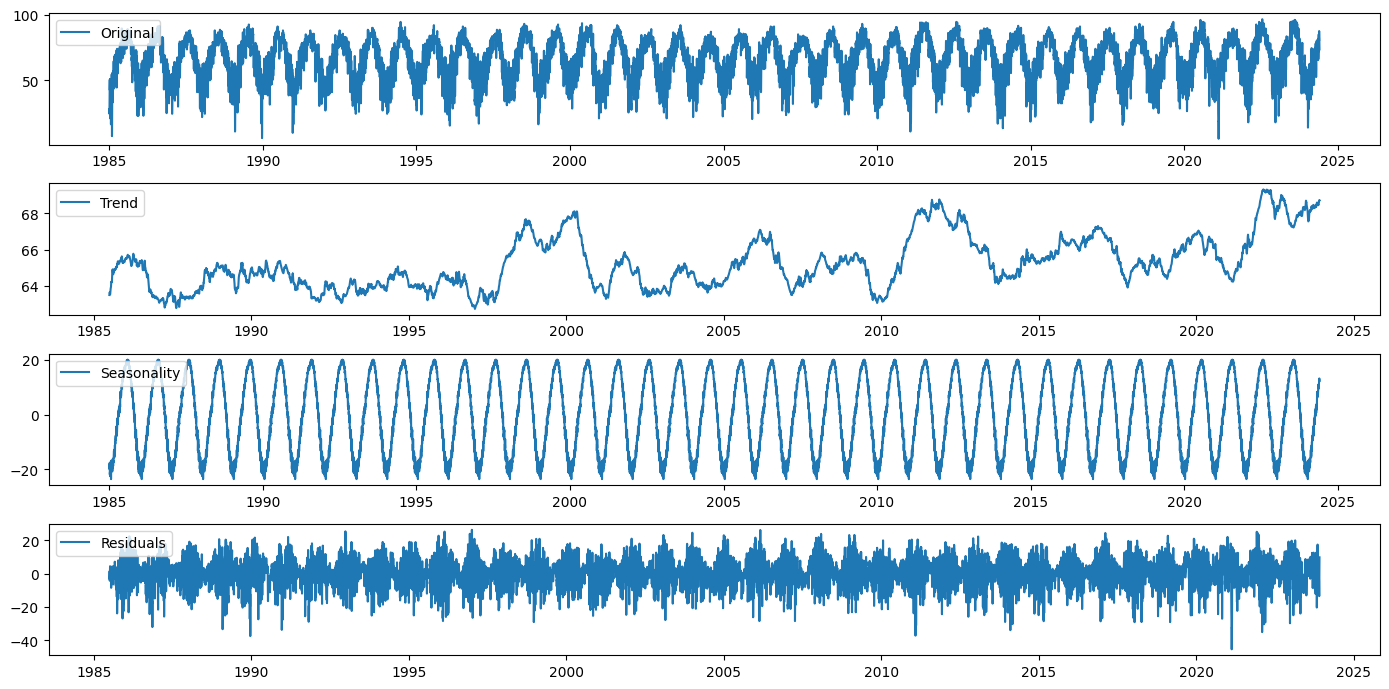

In [35]:
plt.figure(figsize=(14, 7))
plt.subplot(411)
plt.plot(temperature_data['T'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

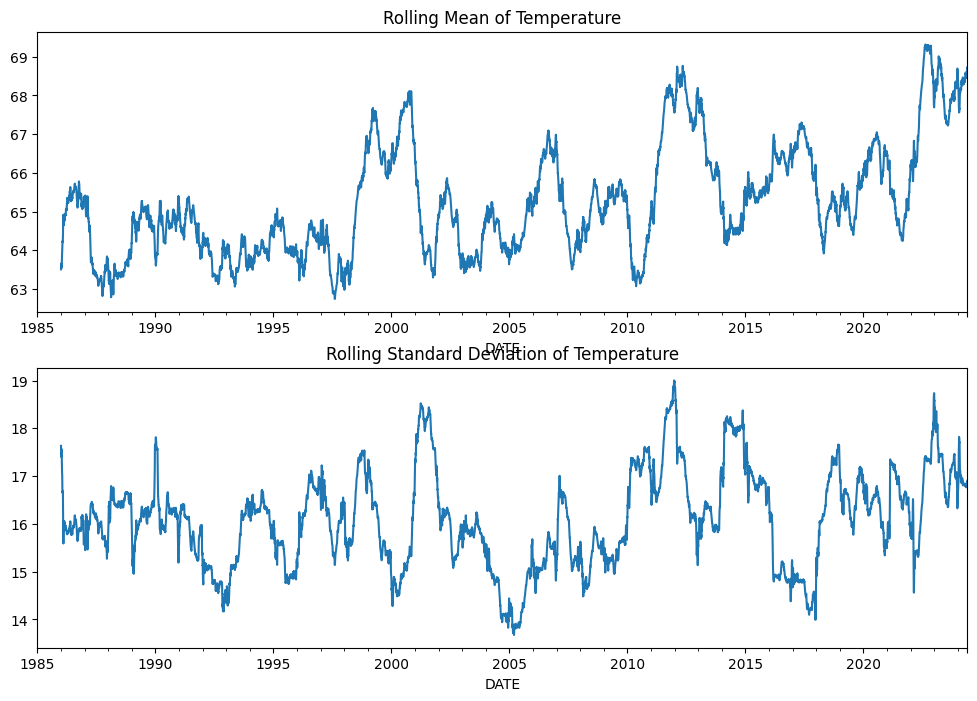

In [36]:
#Rolling statistics
fig, ax = plt.subplots(2, figsize=(12, 8))
temperature_data['T'].rolling(window=365).mean().plot(ax=ax[0], title="Rolling Mean of Temperature")
temperature_data['T'].rolling(window=365).std().plot(ax=ax[1], title="Rolling Standard Deviation of Temperature")
plt.show()

In [37]:
result = adfuller(residual.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -41.24323230753104
p-value: 0.0
Critical Value 1%: -3.4308163123614133
Critical Value 5%: -2.8617460888401176
Critical Value 10%: -2.566879696297656


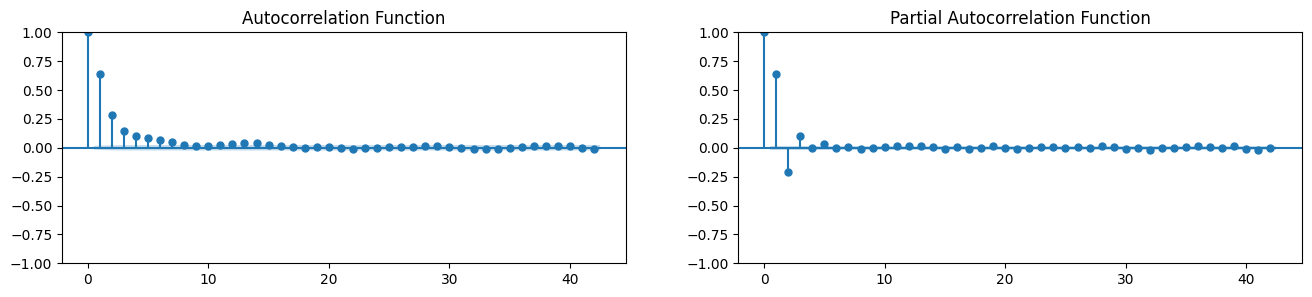

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
plot_acf(residual.dropna(), ax=axes[0], title='Autocorrelation Function')
plot_pacf(residual.dropna(), ax=axes[1], title='Partial Autocorrelation Function')
plt.show()

In [43]:
model = SARIMAX(temperature_data['T'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [47]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                14395
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -47306.836
Date:                            Fri, 12 Jul 2024   AIC                          94623.671
Time:                                    15:22:43   BIC                          94661.540
Sample:                                01-01-1985   HQIC                         94636.261
                                     - 05-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6177      0.009     71.810      0.000       0.601       0.635
ma.L1         -0.9106      0.005   

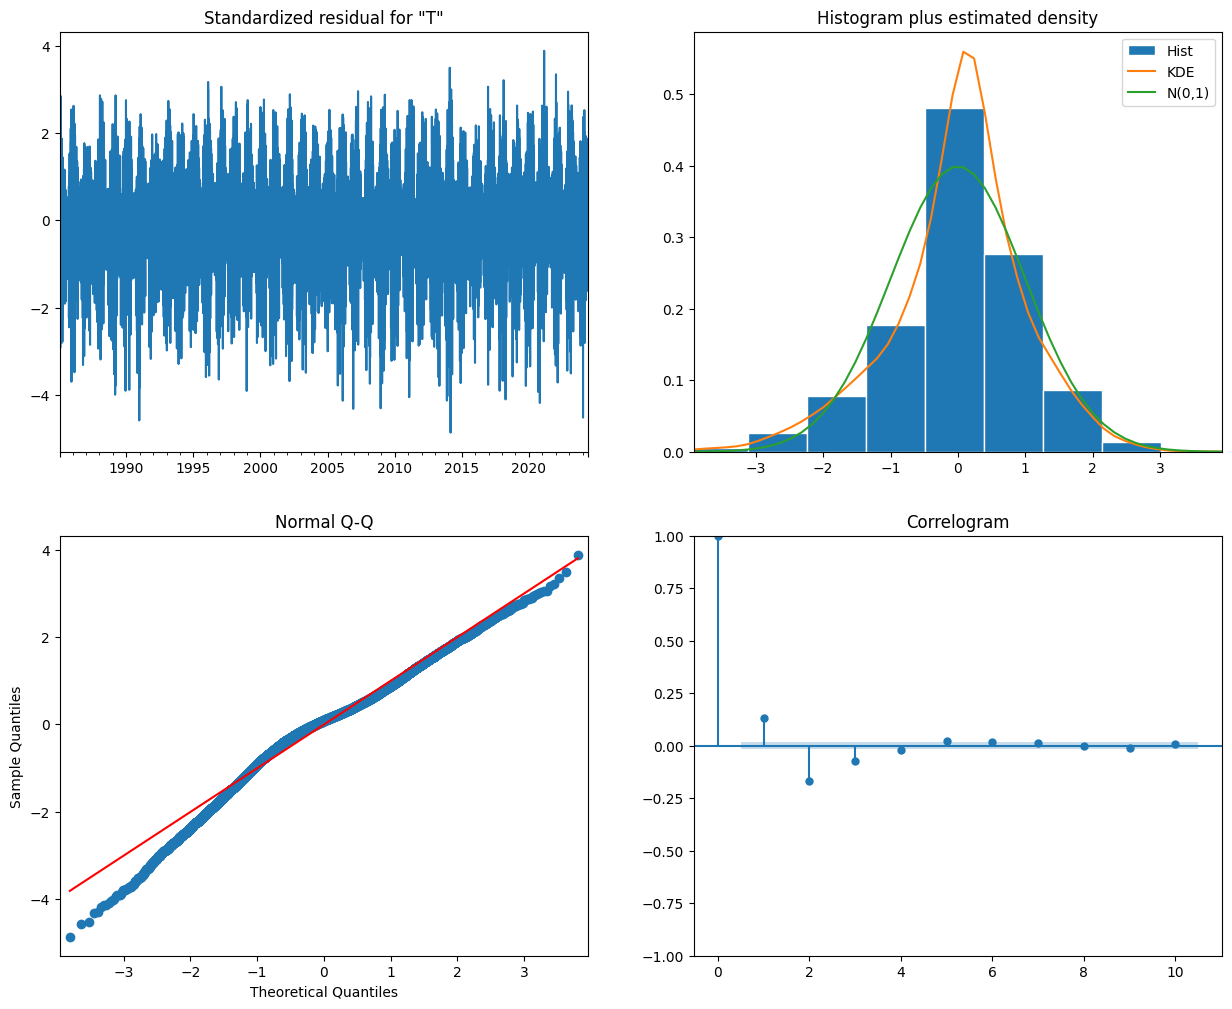

In [48]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [49]:
#Forecasting the next 30 days
forecast = results.get_forecast(steps=30)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

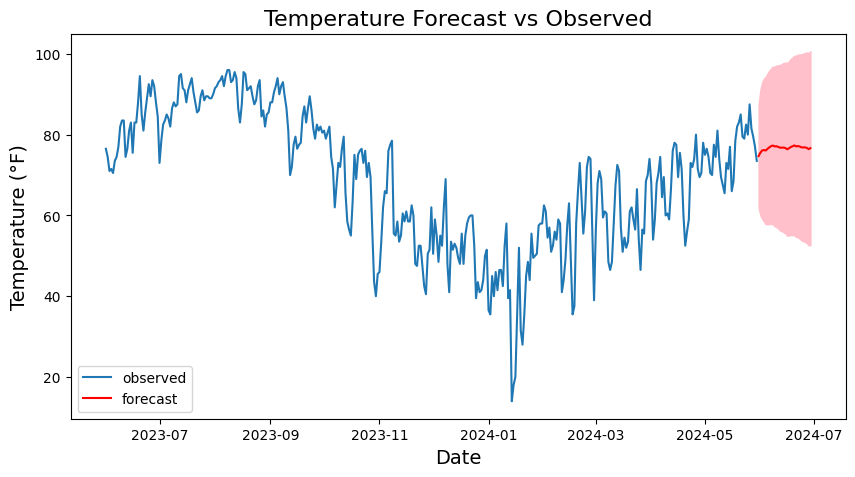

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(temperature_data.index[-365:], temperature_data['T'].tail(365), label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.title('Temperature Forecast vs Observed', fontsize=16) 
plt.xlabel('Date', fontsize=14) 
plt.ylabel('Temperature (°F)', fontsize=14)  
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.show()

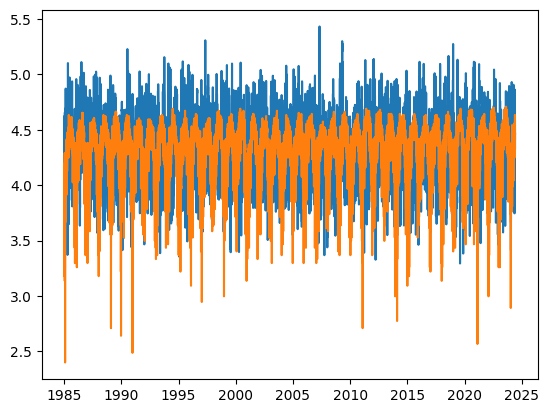

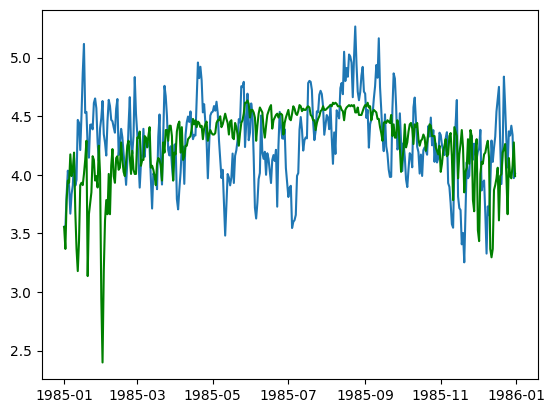

In [86]:
time = temperature_data.index
plt.plot(time,SimulateWeather(np.log(temperature_data['TMAX'])))
plt.plot(time, np.log(temperature_data['TMAX']))
plt.show()
plt.plot(time[:365],SimulateWeather(np.log(temperature_data['TMAX'][:365])))
plt.plot(np.log(temperature_data['TMAX'][:365]), color='green')
plt.show()

In [55]:
#Stochastic Weather Forecasting (Orhenstein Uhlenbeck) Most UPDATED
#T+t+1 = Tt + mean_reversion_rate(mu - Tt)*delta_t + temp_vol*sqrt(delta_t) * zt-- brownian motion
def SimulateWeather(temp_vector):

    #Long-Term Mean
    temperature = temp_vector.values
    mu = temperature.mean()
    var= temperature.var()
    delta_t = 1 
    #deviation_from_mean = temperature- mu
    deviation_from_mean = mu- temperature
    
    #Calculate Rate of Mean Reversion
    vals = (temp_vector - temp_vector.mean()) * (temp_vector.shift().dropna() - temp_vector.mean())
    den = (temp_vector - temp_vector.mean()) ** 2
    mean_reversion_rate = vals.sum()/den.sum()/delta_t
    mean_reversion_rate = -np.log(mean_reversion_rate)
    

    #Calculate Volatility
    observed_changes = np.diff(temperature)
    sigma = np.sqrt(2*mean_reversion_rate* np.var(observed_changes) / (1-np.exp(-2*mean_reversion_rate*delta_t)))
    #sigma = np.sqrt(2 * mean_reversion_rate * np.var(observed_changes))

    
    temp_array = np.zeros(len(temperature))
    temp_array
    temp_array[0] = temperature[0] #Give first value of array as the inital value of temp dataset
    
    calculated_params = pd.DataFrame(index=np.arange(0,1), data={'Mu': mu, 'Sigma': sigma, 'Time-Step' : delta_t,'Rate of Mean Reversion': mean_reversion_rate})
    #display(calculated_params) #Display DF of Calculated Parameters 
    
    #Run simulation:
    for i in range(1,len(temperature)):
        wiener_process = np.random.normal(0,np.sqrt(delta_t)) #Draw a random number from Normal Dist, w/ mean 0 and var = sqrt of delta_t
        temp_array[i] = temp_array[i-1] + mean_reversion_rate*(mu - temp_array[i-1])*delta_t + sigma * wiener_process #T+t+1 = Tt + mean_reversion_rate(mu - Tt)*delta_t + temp_vol*sqrt(delta_t) * zt-- brownian motion
    return temp_array #Return the array of simulated values


max_simulation = SimulateWeather(temperature_data['TMAX'])
min_simulation = SimulateWeather(temperature_data['TMIN'])


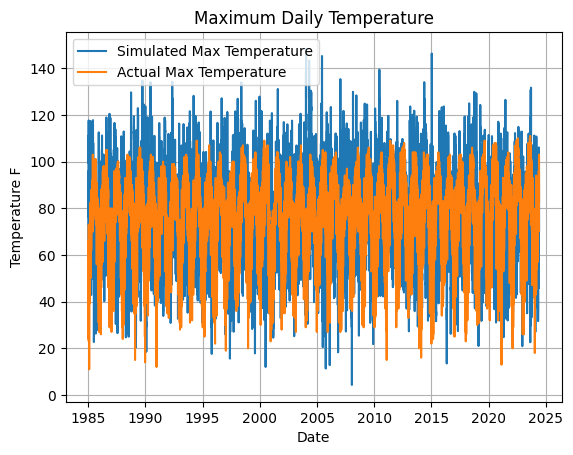

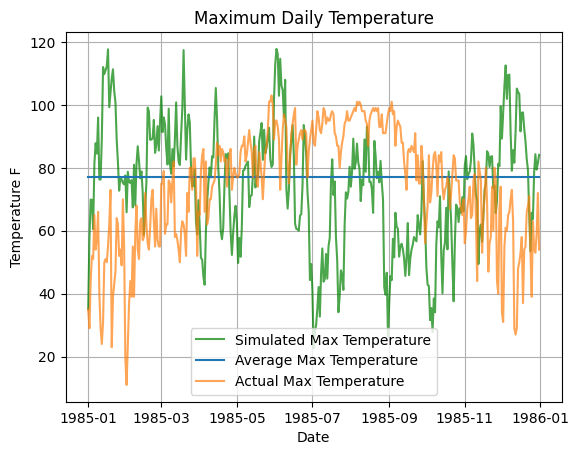

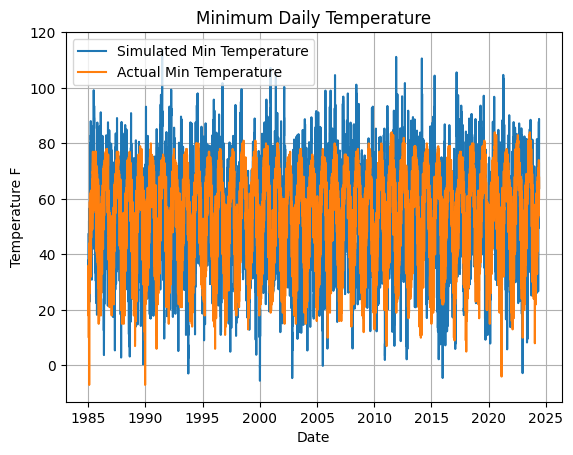

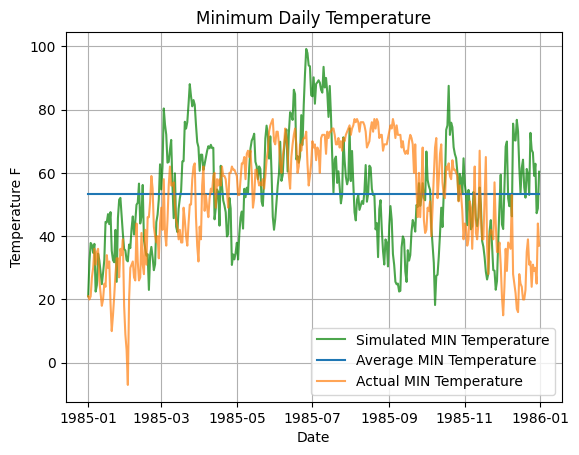

In [56]:
#Plotting One Instance Results
time = temperature_data.index

plt.plot(time,max_simulation,label='Simulated Max Temperature')
plt.plot(temperature_data['TMAX'],label='Actual Max Temperature');plt.grid();plt.legend();plt.title('Maximum Daily Temperature');plt.ylabel('Temperature F');plt.xlabel('Date')
plt.show()

mu_vector = np.array([temperature_data['TMAX'].mean()] *365)
plt.plot(time[0:365],max_simulation[0:365],label='Simulated Max Temperature',color='green',alpha=.7)
plt.plot(time[0:365], mu_vector, label='Average Max Temperature')
plt.plot(temperature_data['TMAX'].iloc[0:365],label='Actual Max Temperature',alpha=.7);plt.grid();plt.legend();plt.title('Maximum Daily Temperature');plt.ylabel('Temperature F');plt.xlabel('Date')
plt.show()


plt.plot(time,min_simulation,label='Simulated Min Temperature')
plt.plot(temperature_data['TMIN'],label='Actual Min Temperature');plt.grid();plt.legend();plt.title('Minimum Daily Temperature');plt.ylabel('Temperature F');plt.xlabel('Date')
plt.show()

mu_vector = np.array([temperature_data['TMIN'].mean()] *365)
plt.plot(time[0:365],min_simulation[0:365],label='Simulated MIN Temperature',color='green',alpha=.7)
plt.plot(time[0:365], mu_vector, label='Average MIN Temperature')
plt.plot(temperature_data['TMIN'].iloc[0:365],label='Actual MIN Temperature',alpha=.7);plt.grid();plt.legend();plt.title('Minimum Daily Temperature');plt.ylabel('Temperature F');plt.xlabel('Date')
plt.show()




In [57]:
def estimation_errors(simulated_vector, real_vector):
    mean_abs_error = (np.sum(np.abs(real_vector - simulated_vector)))/len(simulated_vector)

    return mean_abs_error

max_sim_error = estimation_errors(max_simulation,temperature_data['TMAX'])
print(f'MAE One Simulation for Max Daily Temp: {max_sim_error}')

min_sim_error = estimation_errors(min_simulation,temperature_data['TMAX'])
print(f'MAE One Simulation for Min Daily Temp: {min_sim_error}')



MAE One Simulation for Max Daily Temp: 20.06720929903
MAE One Simulation for Min Daily Temp: 28.342438245559034


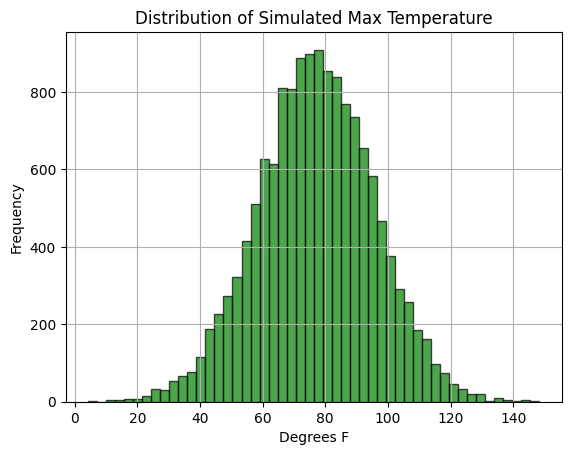

Text(0, 0.5, 'Frequency')

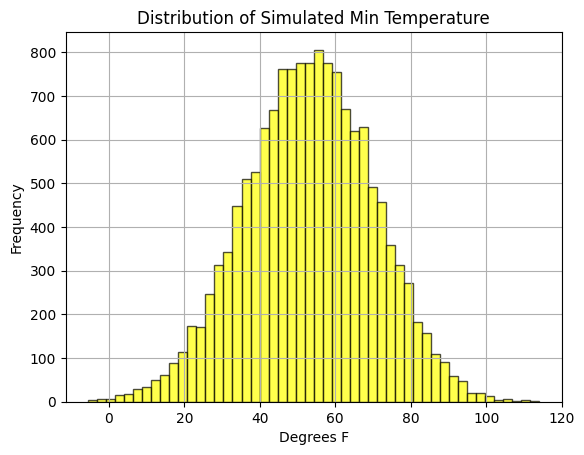

In [58]:
#Plotting One Run Hist & KDE
max_series = pd.Series(max_simulation)
min_series = pd.Series(min_simulation)

max_series.hist(color='green',alpha=.7,edgecolor='black',bins=50);plt.title('Distribution of Simulated Max Temperature');plt.xlabel('Degrees F');plt.ylabel('Frequency')
plt.show()

min_series.hist(color='yellow',alpha=.7,edgecolor='black',bins=50);plt.title('Distribution of Simulated Min Temperature');plt.xlabel('Degrees F');plt.ylabel('Frequency')

In [59]:
#Cooling Day Degrees & Heating Day Degrees

#Taken FROM CME:
#HDD = Max(0, 65°F - daily average temperature)
#CDD = Max(0, daily average temperature - 65°F

day_deg = pd.DataFrame(data ={'Max' : max_simulation,'Min' :min_simulation})
day_deg['Daily Average Temperature'] = day_deg.mean(axis=1)
day_deg['HDD'] = day_deg['Daily Average Temperature'].apply(lambda x: max(0, 65 - x))
day_deg['CDD'] = day_deg['Daily Average Temperature'].apply(lambda x: max(0, x - 65))
day_deg.head()

day_deg['Rolling Monthly HDD'] = day_deg['HDD'].rolling(window=30).sum()
day_deg['Rolling Monthly CDD'] = day_deg['CDD'].rolling(window=30).sum()

day_deg = day_deg.dropna()

day_deg.head()

#Apply an Arbitrary Threshold for testing
day_deg['Strike'] = 300 
day_deg['HDD Pay Off Call'] = day_deg['Rolling Monthly HDD'].apply(lambda x: max(0, x - 300))
day_deg['ITM'] = day_deg['HDD Pay Off Call'] > 0 
day_deg.head()


,Max,Min,Daily Average Temperature,HDD,CDD,Rolling Monthly HDD,Rolling Monthly CDD,Strike,HDD Pay Off Call,ITM
29,74.733275,35.922922,55.328098,9.671902,0.0,187.055164,95.425237,300,0.0,False
30,77.559303,35.489060,56.524182,8.475818,0.0,158.530982,95.425237,300,0.0,False
31,65.873655,32.448690,49.161172,15.838828,0.0,154.127252,95.425237,300,0.0,False
32,78.705357,32.035474,55.370416,9.629584,0.0,152.646340,95.425237,300,0.0,False
33,75.544808,37.345498,56.445153,8.554847,0.0,149.690134,95.425237,300,0.0,False


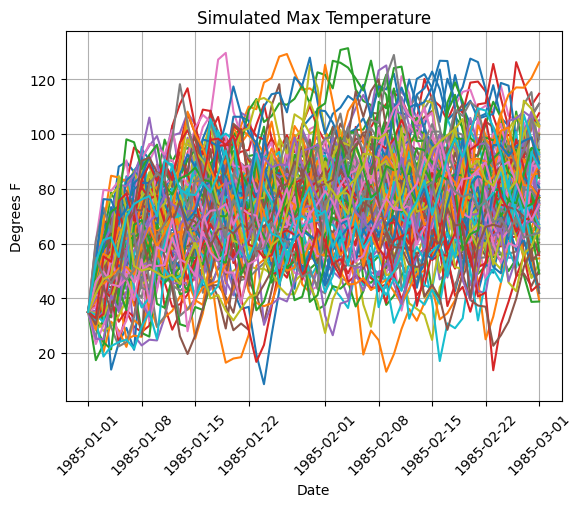

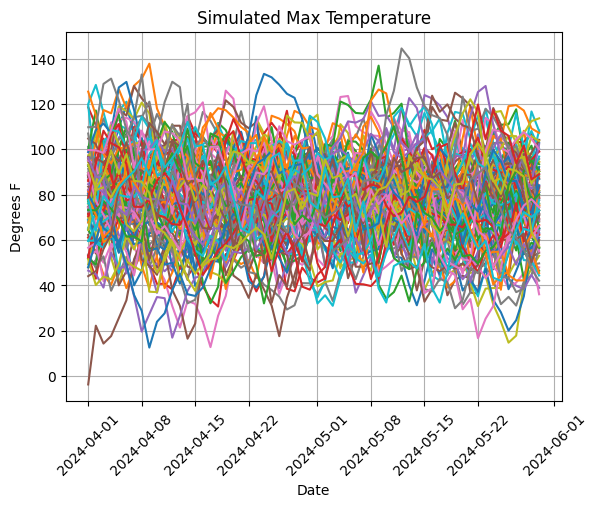

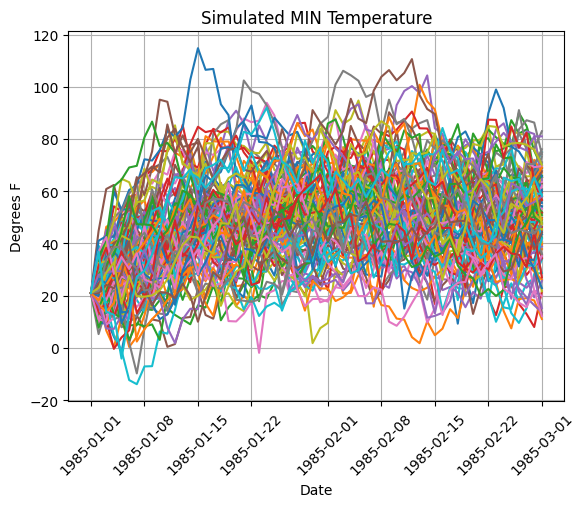

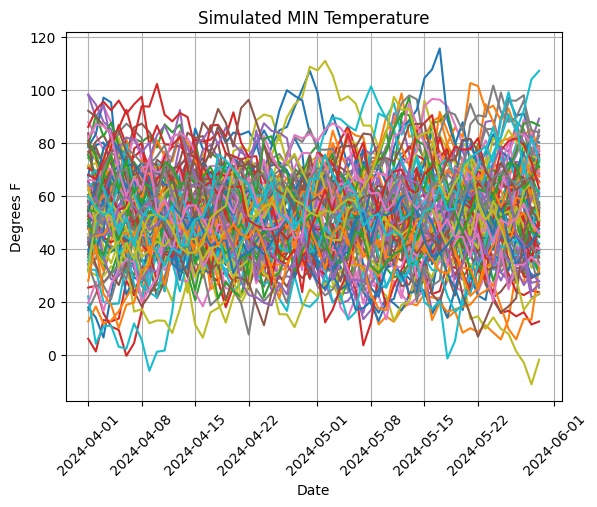

In [60]:
def monte_carlo_sim(temp_vector, title, xaxislabel,yaxislabel):
    time = temperature_data.index
    sim_lc = []
    for i in range(100):
        sim_lc.append(SimulateWeather(temp_vector))
    sim_sliced = [arr[:60] for arr in sim_lc]
    for i in range(len(sim_sliced)):
        plt.plot(time[:60], sim_sliced[i]);plt.xticks(rotation=45);plt.xlabel(xaxislabel);plt.ylabel(yaxislabel);plt.title(title);plt.grid(True)
    plt.show()
    
    last_values = [arr[-60:] for arr in sim_lc]
    
    for i in range(len(last_values)):
        plt.plot(time[-60:], last_values[i]);plt.xticks(rotation=45);plt.xlabel(xaxislabel);plt.ylabel(yaxislabel);plt.title(title);plt.grid(True)
    plt.show()
    return sim_lc 

tmax_sim_temps= monte_carlo_sim(temperature_data['TMAX'], 'Simulated Max Temperature', 'Date','Degrees F')  
tmin_sim_temps= monte_carlo_sim(temperature_data['TMIN'], 'Simulated MIN Temperature', 'Date','Degrees F')  




In [62]:
#Find Average Temperature For Each Simulation Over Duration of the Time Period
def find_avg_temps(simulation_array):
    mean_lc = []
    for i in range(len(simulation_array)):
        mean_val = np.mean(simulation_array[i])
        mean_lc.append(mean_val)
        
    return mean_lc 

mean_max = find_avg_temps(tmax_sim_temps)
mean_min = find_avg_temps(tmin_sim_temps)

simulated_avg_df = pd.DataFrame(data = {'Max Average Temperatures' : mean_max, 'Min Average Temperatures' : mean_min})
simulated_avg_df.index.name = 'Simulations'
display(simulated_avg_df.head())

max_avg = simulated_avg_df['Max Average Temperatures'].mean()
min_avg = simulated_avg_df['Min Average Temperatures'].mean()
simualation_num = len(simulated_avg_df['Max Average Temperatures'])

print(f'Simulated Average Max Temperature: {max_avg} On {simualation_num} Simulations')
print(f'Simulated Average Min Temperature: {min_avg} On {simualation_num} Simulations')

simulated_avg_df['Daily Mean Temperature Simulation'] =simulated_avg_df.mean(axis=1)
simulated_avg_df.head()



,Max Average Temperatures,Min Average Temperatures
Simulations,,
0,76.864251,53.349242
1,77.520179,53.158484
2,76.743747,53.673681
3,76.215087,53.707551
4,76.861485,53.014308


Simulated Average Max Temperature: 76.96867684592107 On 100 Simulations
Simulated Average Min Temperature: 53.360369697931475 On 100 Simulations


,Max Average Temperatures,Min Average Temperatures,Daily Mean Temperature Simulation
Simulations,,,
0,76.864251,53.349242,65.106746
1,77.520179,53.158484,65.339332
2,76.743747,53.673681,65.208714
3,76.215087,53.707551,64.961319
4,76.861485,53.014308,64.937896


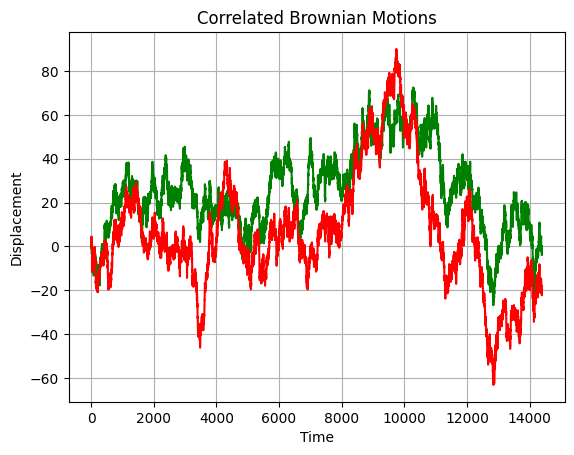

In [65]:
#Create Correlated Brownian Motion 
correl = .7  #specified level of correlation
correl_matrix = np.array([[1,correl], [correl,1]]) #Create a correlation matrix

#Using Cholesky Decomposition
lower_tri_matrix = np.array([[1,0],[correl,np.sqrt(1-correl**2)]]) #Create the lower triangle of the correl matrix

#Generate Random Brownian Motions
w1 = np.random.normal(0,np.sqrt(1),14395)
w2 = np.random.normal(0,np.sqrt(1),14395)

#Put w1 and w2 into a 2x2 matrix 
w_matrix = [w1,w2] 

correlated_brownian_motions = lower_tri_matrix @ w_matrix #Dot Product with Lower Triangle Matrix

brown1 = correlated_brownian_motions[0].cumsum(); brown2 = correlated_brownian_motions[1].cumsum(); x_vector = np.arange(0,14395)

#Correlated Graphs
plt.plot(x_vector,brown1, label='Brownian Motion 1',color='green');plt.plot(x_vector,brown2, label = 'Brownian Motion 2',color='red');plt.title('Correlated Brownian Motions');plt.xlabel('Time');plt.ylabel('Displacement');plt.grid(True)

In [66]:
#Price Weather Call Option Using Simulated Weather as Underlying 
def black_scholes_call(spot, strike, t, sigma, rf ):
    d1 = (np.log(spot/strike) + (rf* sigma**2/2) * t/ (np.sqrt(t) * sigma))
    d2 = d1 - sigma * np.sqrt(t)
    price = spot * norm.cdf(d1) - strike* np.exp(-rf * t) * norm.cdf(d2)
    return price
   
spot =80
strike =100
t = 5/12
rf =.05 

sigma = np.std(temperature_data['TMAX'])
black_scholes_call(80,100,5/12,sigma,.05)

call_values = np.zeros(len(simulated_avg_df))

#Calculate Black-Scholes Option Call Based on Average Temperature From Simulation 
for i in range(len(simulated_avg_df)):
    call_values[i] = black_scholes_call(simulated_avg_df['Daily Mean Temperature Simulation'].iloc[i],strike,t, sigma,rf)
    
    
simulated_avg_df['Call Values'] = call_values
simulated_avg_df.head()

,Max Average Temperatures,Min Average Temperatures,Daily Mean Temperature Simulation,Call Values
Simulations,,,,
0,76.864251,53.349242,65.106746,28.496920
1,77.520179,53.158484,65.339332,28.690565
2,76.743747,53.673681,65.208714,28.581770
3,76.215087,53.707551,64.961319,28.376033
4,76.861485,53.014308,64.937896,28.356577


-------------------------------------------------------------------

In [67]:
# Define CARMA(3) parameters based on the research paper for Vilnius
alpha = [2.034, 1.311, 0.187]
sigma = np.sqrt(5.76)
C = 65  # Cutoff temperature in Fahrenheit (equivalent to 18°C)

In [68]:
# Define CARMA(3) matrix
A = np.array([[0, 1, 0], [0, 0, 1], [-alpha[2], -alpha[1], -alpha[0]]])
b = np.array([0, 0, 1])

In [69]:
# Define CARMA(3) matrix and simulation function
def simulate_CARMA(n_steps, dt, A, b, sigma):
    n_vars = A.shape[0]
    X = np.zeros((n_steps, n_vars))
    W = np.random.normal(0, np.sqrt(dt), (n_steps, n_vars))
    
    for t in range(1, n_steps):
        dX = dt * (A @ X[t-1]) + sigma * (b * W[t])
        X[t] = X[t-1] + dX
        
    return X[:, 0]  # Return only the first variable as the temperature

In [70]:
# Simulation parameters
n_steps = 365  # 1 year of daily data
dt = 1  # daily time step

# Simulate the CARMA process
carma_sim = simulate_CARMA(n_steps, dt, A, b, sigma)
temps = 18 + simulate_CARMA(n_steps, dt, A, b, sigma)

In [71]:
# Calculate HDD and CDD using a lambda function directly
calculate_degree_days = lambda temps, base_temp: (np.maximum(0, base_temp - temps), np.maximum(0, temps - base_temp))
base_temp_C = 18  # Base temperature in Celsius for HDD and CDD

In [72]:
HDD, CDD = calculate_degree_days(temps, base_temp_C)

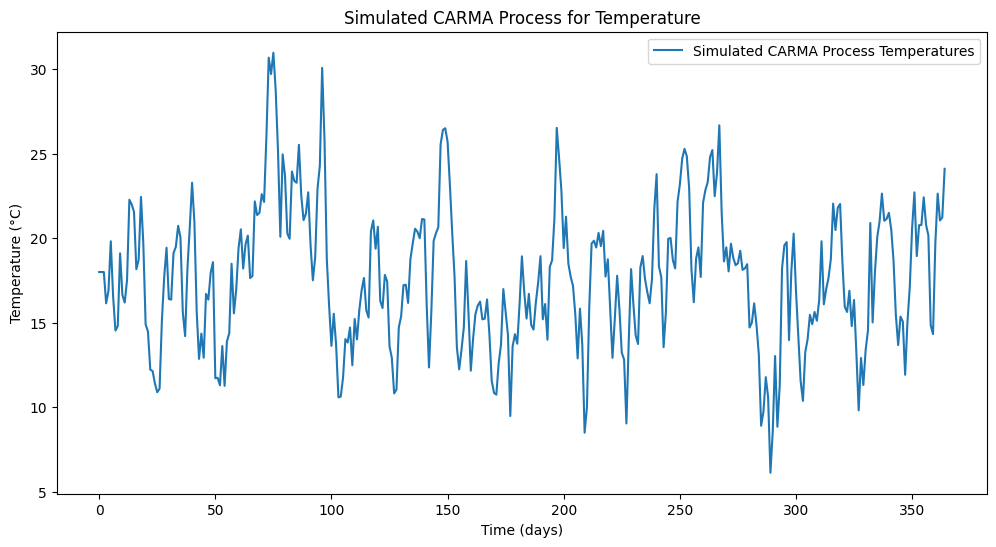

In [73]:
# Plot the simulated CARMA process temperatures
plt.figure(figsize=(12, 6))
plt.plot(temps, label='Simulated CARMA Process Temperatures')
plt.title('Simulated CARMA Process for Temperature')
plt.xlabel('Time (days)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


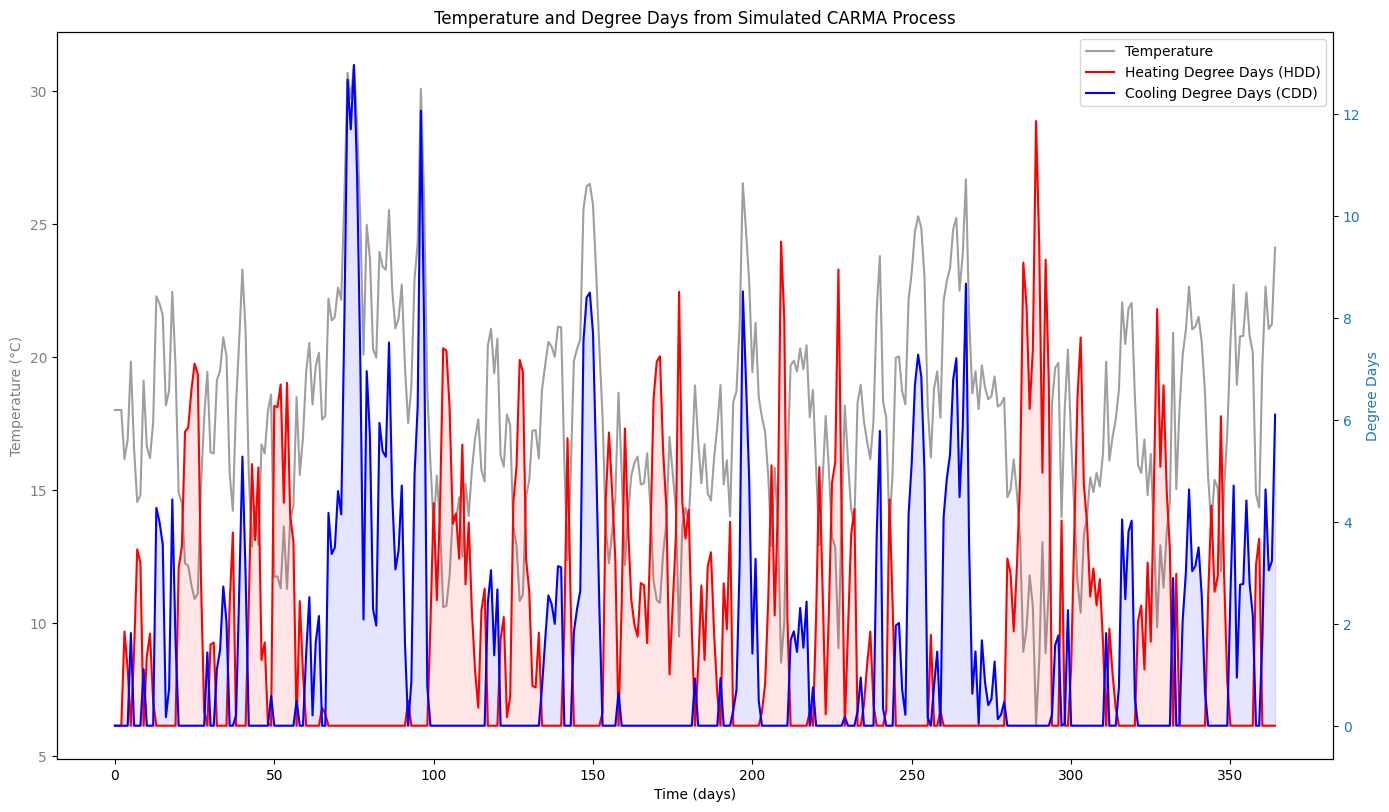

In [74]:
# Plot the simulated CARMA process temperatures with HDD and CDD
fig, ax1 = plt.subplots(figsize=(14, 8))

# Create the primary y-axis for the temperature data
color = 'tab:gray'
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.plot(temps, color=color, alpha=0.75, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis for the degree days
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Degree Days', color=color)  # we already handled the x-label with ax1
ax2.plot(HDD, color='red', label='Heating Degree Days (HDD)')
ax2.plot(CDD, color='blue', label='Cooling Degree Days (CDD)')
ax2.tick_params(axis='y', labelcolor=color)

# Fill the area under HDD and CDD plots
ax2.fill_between(range(len(HDD)), 0, HDD, color='red', alpha=0.1)
ax2.fill_between(range(len(CDD)), 0, CDD, color='blue', alpha=0.1)

# Added a legend with all handles
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

fig.tight_layout()  # to make sure layout doesn't overlap
plt.title('Temperature and Degree Days from Simulated CARMA Process')
plt.show()

In [75]:
# Pricing futures derivatives based on CARMA model
def price_futures_CARMA(HDD, CDD, beta_HDD, beta_CDD, risk_free_rate, time_to_maturity):
    discounted_HDD = np.exp(-risk_free_rate * time_to_maturity) * np.sum(HDD)
    discounted_CDD = np.exp(-risk_free_rate * time_to_maturity) * np.sum(CDD)
    
    futures_price = beta_HDD * discounted_HDD + beta_CDD * discounted_CDD
    return futures_price

In [76]:
# Define risk-free rate and time to maturity (example values)
risk_free_rate = 0.05
time_to_maturity = 30 / 365  # 30 days to maturity

# Estimate beta coefficients based on historical data 
beta_HDD = 1.2
beta_CDD = 1.1

In [77]:
# Price the futures contract
futures_price = price_futures_CARMA(HDD[:n_steps], CDD[:n_steps], beta_HDD, beta_CDD, risk_free_rate, time_to_maturity)
print(f"Futures Price for the first {n_steps} days: {futures_price}")

Futures Price for the first 365 days: 1407.356045680307


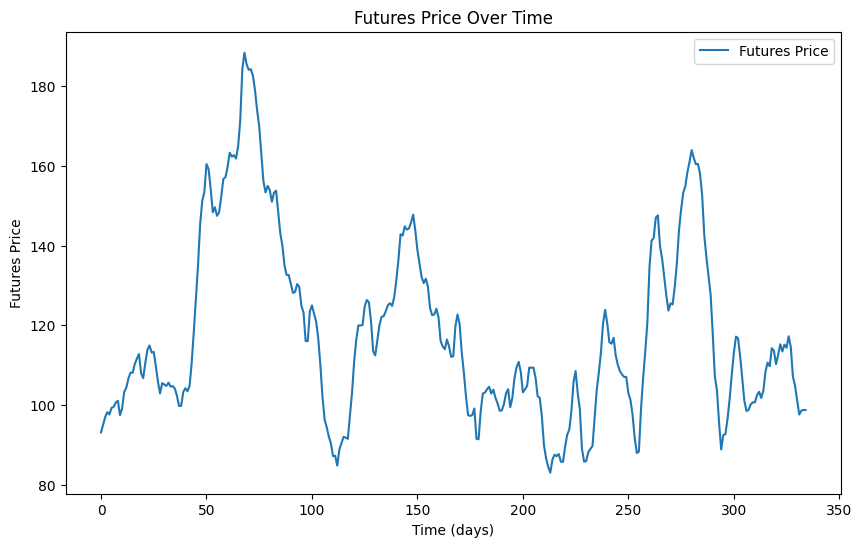

In [78]:
# Plot the futures price over the entire period
futures_prices = [price_futures_CARMA(HDD[i:i+30], CDD[i:i+30], beta_HDD, beta_CDD, risk_free_rate, time_to_maturity)
                  for i in range(len(HDD) - 30)]

plt.figure(figsize=(10, 6))
plt.plot(futures_prices, label='Futures Price')
plt.title('Futures Price Over Time')
plt.xlabel('Time (days)')
plt.ylabel('Futures Price')
plt.legend()
plt.show()

In [79]:
def calculate_hedge_positions(temps, HDD, CDD, base_temp=65, strike_price=65, window=30):
    # Calculate dynamic hedge positions based on CDD and HDD relative to a strike price
    hedge_positions = []
    n = len(temps)
    for i in range(n - window + 1):
        # Calculate payoff differences for HDD and CDD
        payoff_HDD = np.maximum(0, base_temp - temps[i:i+window]) - strike_price
        payoff_CDD = np.maximum(0, temps[i:i+window] - base_temp) - strike_price
        # Summing up the differences over the window to simulate the contract payoff
        hedge_value = np.sum(payoff_HDD - payoff_CDD)
        hedge_positions.append(hedge_value)
    return hedge_positions

In [80]:
# Generate synthetic temperature data to simulate CARMA outputs for example
np.random.seed(0)
temps = np.random.normal(18, 5, 365)  # Mean temp of 18°C with some noise

# Calculate HDD and CDD using a simple cutoff of 65°F (approx 18°C)
HDD = np.maximum(0, 65 - temps)
CDD = np.maximum(0, temps - 65)

In [81]:
# Calculate hedge positions for a given window
hedge_positions = calculate_hedge_positions(temps, HDD, CDD)


In [82]:
# Example plot for single location (similar to Figure 1)
def plot_hedge_and_temp(temps, HDD, CDD, temp_cutoff, strike_price, start_day, end_day):
    # Calculate degree days using the temp_cutoff
    HDD, CDD = calculate_degree_days(temps, temp_cutoff)
    
    # Calculate hedge positions
    hedge_positions = calculate_hedge_positions(HDD[start_day:end_day], CDD[start_day:end_day], strike_price)
    
    # Adjusting the length of the hedge_positions to match the time range
    days = np.arange(start_day, start_day + len(hedge_positions))

    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot hedge positions
    ax1.plot(days, hedge_positions, 'b-', label='Hedge position')
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Hedge position', color='b')
    ax1.tick_params('y', colors='b')
    
    # Plot temperatures
    ax2 = ax1.twinx()
    ax2.plot(days, temps[start_day:start_day + len(hedge_positions)], 'r--', label='Temperature')
    ax2.set_ylabel('Celsius', color='r')
    ax2.tick_params('y', colors='r')
    
    fig.tight_layout()
    plt.title(f'Hedge in CDD-futures when cutoff is C = {temp_cutoff} and strike = {strike_price}')
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.show()

In [83]:
# Plot for correlated temperature dynamics (similar to Figure 4)
def plot_correlated_hedge(temps1, temps2, HDD1, HDD2, CDD1, CDD2, temp_cutoff, strike_price, start_day, end_day, rho):
    hedge_positions = []
    for i in range(start_day, end_day):
        hdd_payoff1 = np.maximum(0, HDD1[i] - strike_price)
        cdd_payoff1 = np.maximum(0, CDD1[i] - strike_price)
        hdd_payoff2 = np.maximum(0, HDD2[i] - strike_price)
        cdd_payoff2 = np.maximum(0, CDD2[i] - strike_price)
        hedge_positions.append(hdd_payoff1 - cdd_payoff1 + rho * (hdd_payoff2 - cdd_payoff2))
    
    days = np.arange(start_day, end_day)

    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    ax1.plot(days, hedge_positions, 'b-', label='Hedge position')
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Hedge position', color='b')
    ax1.tick_params('y', colors='b')
    
    ax2 = ax1.twinx()
    ax2.plot(days, temps1[start_day:end_day], 'r--', label='Temperature in Location 1')
    ax2.plot(days, temps2[start_day:end_day], 'k--', label='Temperature in Location 2')
    ax2.set_ylabel('Celsius', color='r')
    ax2.tick_params('y', colors='r')
    
    fig.tight_layout()
    plt.title(f'Hedge in CDD-futures with correlated temperature dynamics')
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.show()

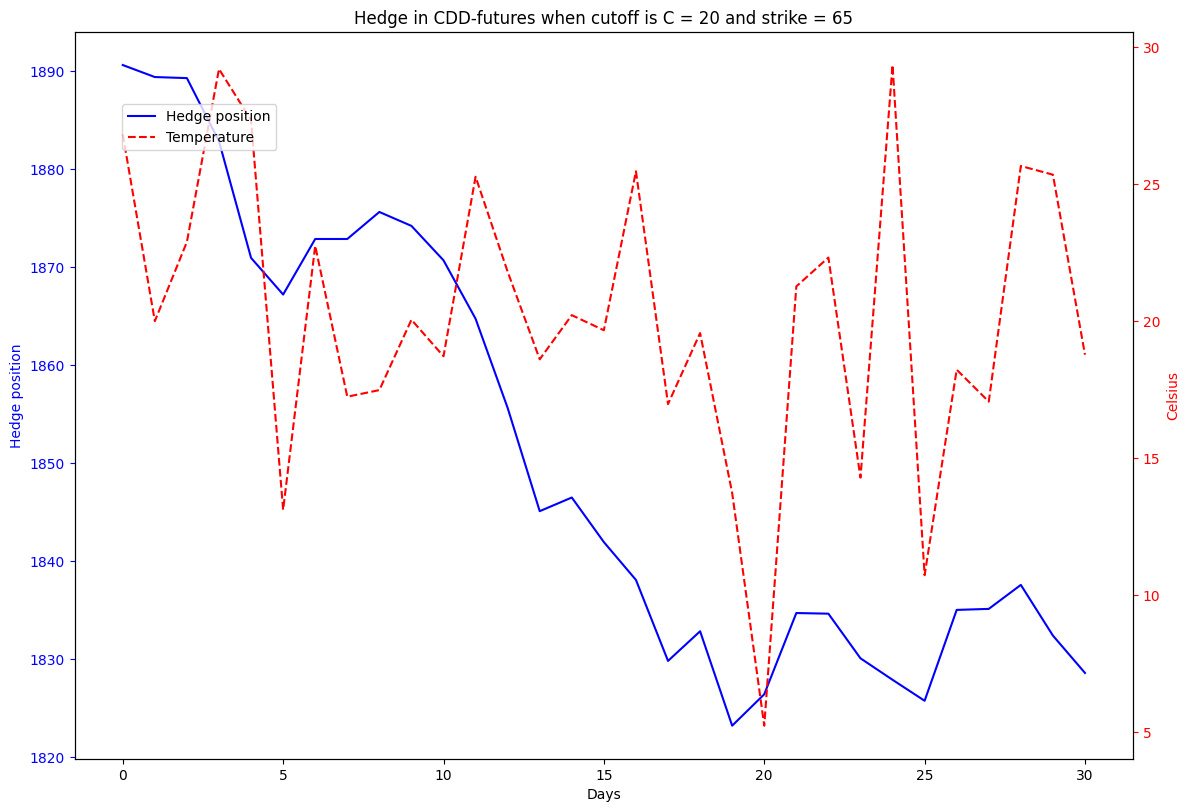

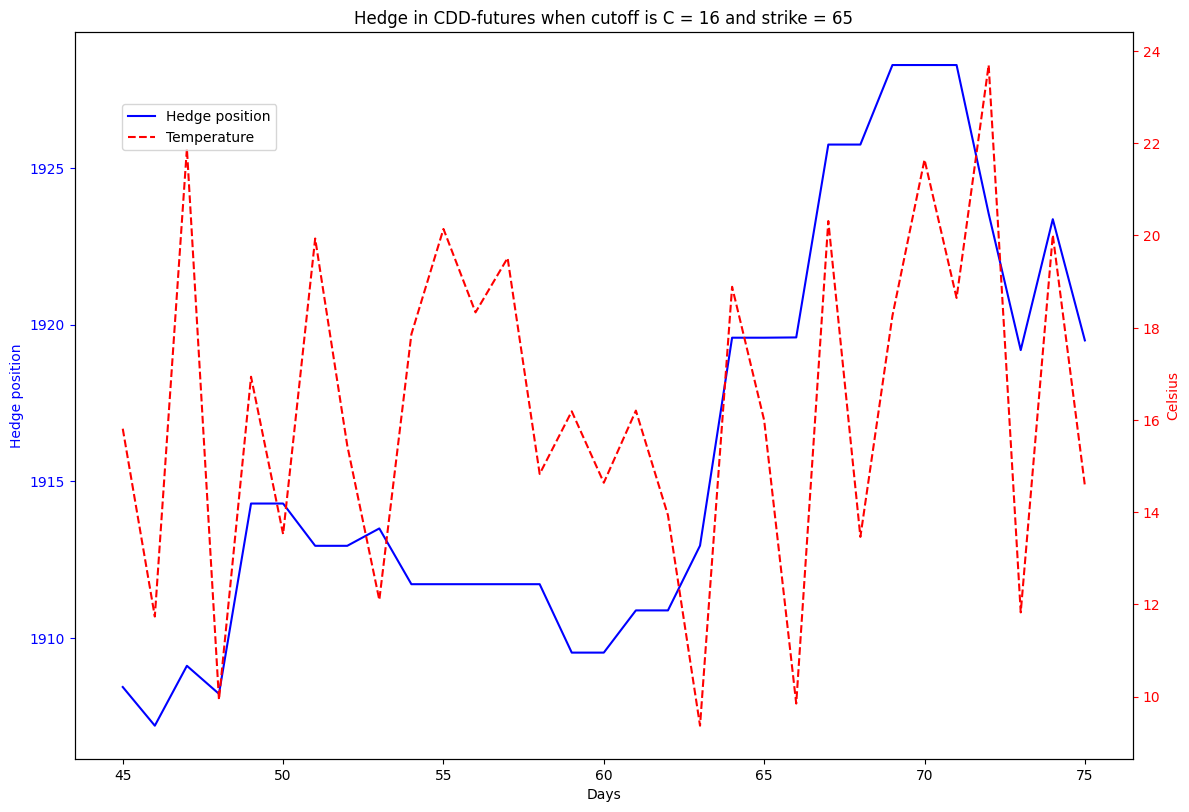

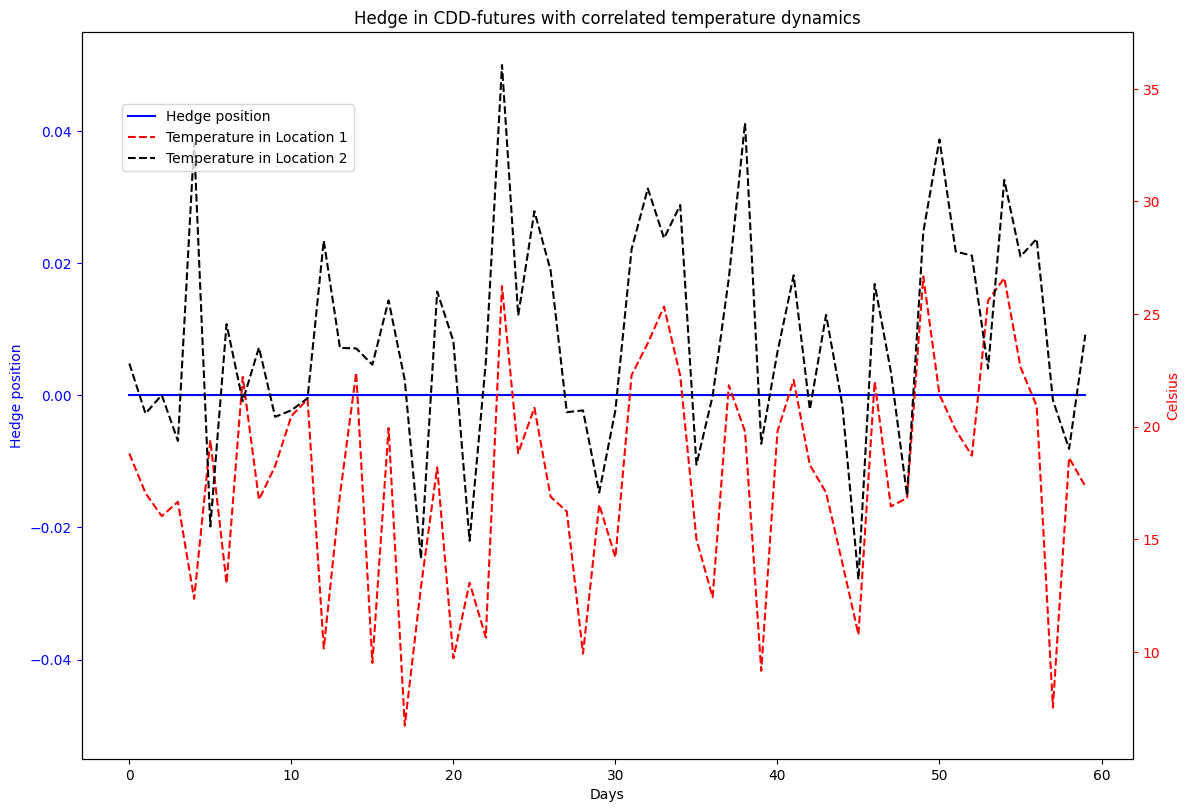

In [84]:
# Generate synthetic temperature data to simulate CARMA outputs for example
np.random.seed(0)
temps = np.random.normal(18, 5, 365)  # Mean temp of 18°C with some noise

# Calculate HDD and CDD using a simple cutoff of 65°F (approx 18°C)
HDD, CDD = calculate_degree_days(temps, 65)

# Plot for Figure 1 with temp_cutoff = 20, strike_price = 65, start_day = 0, end_day = 60
plot_hedge_and_temp(temps, HDD, CDD, 20, 65, 0, 60)

# Plot for Figure 3 with temp_cutoff = 16, strike_price = 65, start_day = 45, end_day = 105
plot_hedge_and_temp(temps, HDD, CDD, 16, 65, 45, 105)

# Simulate two correlated temperature series for the example
carma_sim1 = np.random.normal(18, 5, 365)
carma_sim2 = np.random.normal(18, 5, 365)
rho = 0.5
carma_sim2 = rho * carma_sim1 + np.sqrt(1 - rho**2) * carma_sim2

# Calculate HDD and CDD for both locations
HDD1, CDD1 = calculate_degree_days(carma_sim1, 65)
HDD2, CDD2 = calculate_degree_days(carma_sim2, 65)

# Plot for Figure 4 with temp_cutoff = 16, strike_price = 65, start_day = 0, end_day = 60, rho = 0.5
plot_correlated_hedge(carma_sim1, carma_sim2, HDD1, HDD2, CDD1, CDD2, 16, 65, 0, 60, 0.5)